# Project Notebook
##### Created by Dario Sandrucci 48436

bla bla bla

### 0. Import Packages

In [1]:
from data_engineering import *
from denoising_and_detoning import *
from algorithm import *
from portfolio_and_backtesting import *

### 1. Data Preparation and Exploration

##### 1.1 Loading Data

Let import return data from S&P 500 stocks over the period of approximately the last 10 years.

In [2]:
tickers = getTickers()
end = dt.now()
start = dt.fromisoformat('2012-10-15')
df = getData(start, end, tickers, downloaded = True)

Data was loaded sucessfully!


##### 1.2 Data Visualization

A chart the shows the percentage returns over the period of the sample.

Text(0.5, 1.0, 'Log Returns of S&P500 Stocks for Training Period')

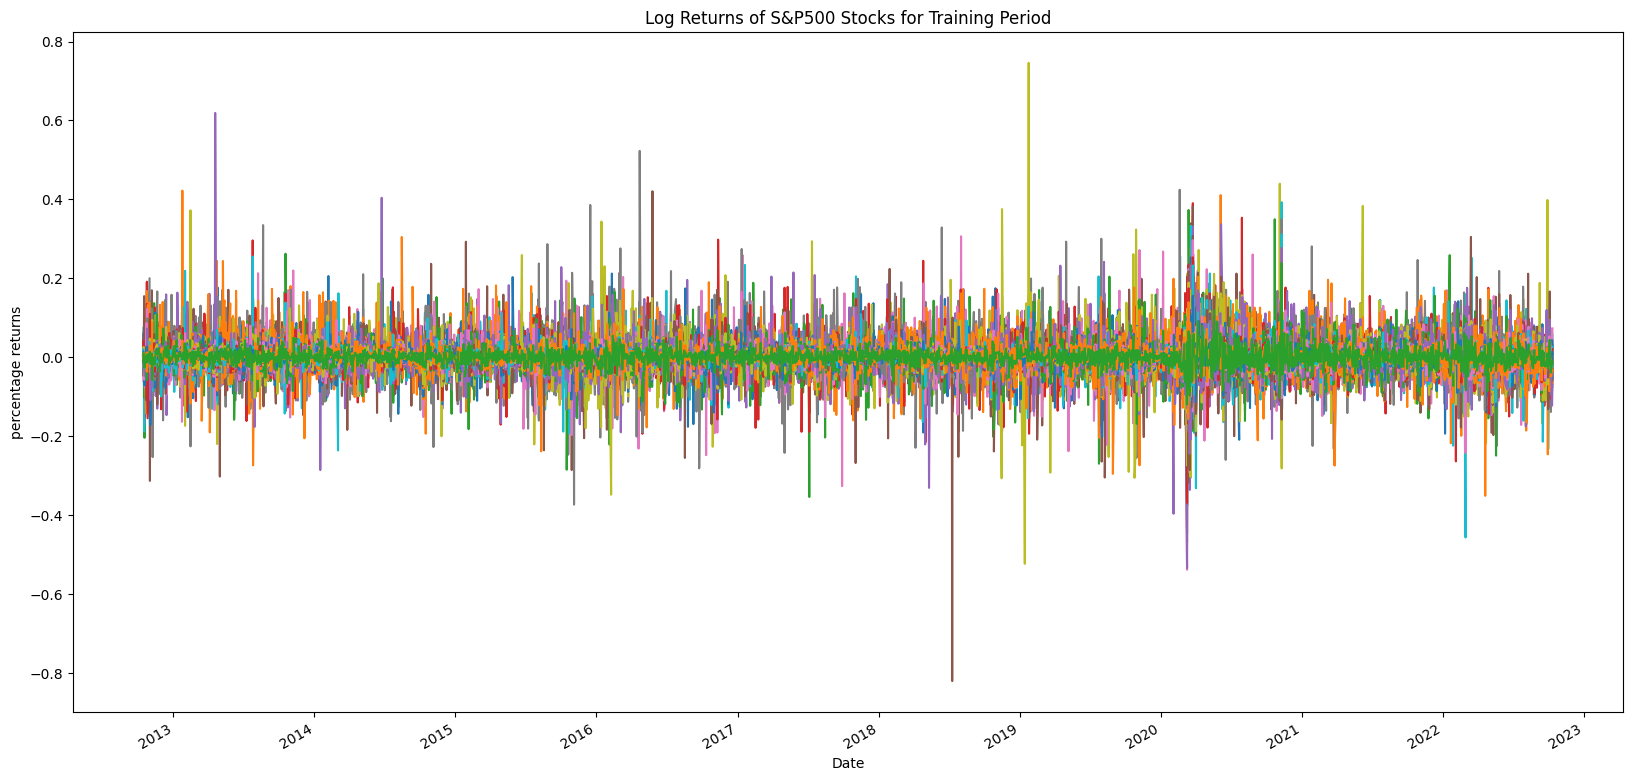

In [3]:
ax = df.plot(legend=False, figsize=(20,10))
ax.set_ylabel('percentage returns')
ax.set_title('Log Returns of S&P500 Stocks for Training Period')

A chart to show the cummulative returns of the SPY index over the data period.

Text(0.5, 1.0, 'Cummulative returns of the S&P 500 Index over the period of the data set')

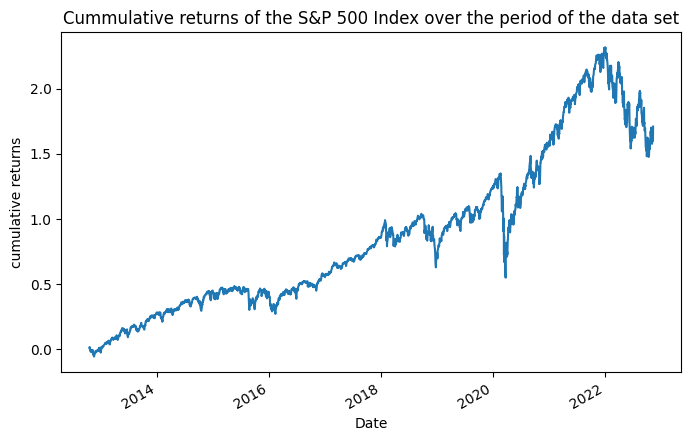

In [4]:
spy_returns = pdr.get_data_yahoo(["SPY"], start, end)["Close"]
spy_returns = spy_returns.pct_change().dropna(axis = 0)
spy_cum = np.cumprod(1 + spy_returns) - 1
spy_cum.columns = ["S&P 500 Index"]

ax = spy_cum.plot(legend=False, figsize=(8,5))
ax.set_ylabel('cumulative returns')
ax.set_title('Cummulative returns of the S&P 500 Index over the period of the data set')

##### 1.3 Data Transformation

We will split the set into train and test set.

In [5]:
train_set, test_set = testTrainSplit(df, validation_set = False, w_tt = [0.9, 0.1])

Now lets derive the empirical correlation matrix of our return data.

In [6]:
corr0 = pd.DataFrame(getCorrMatrix(train_set), index = train_set.columns, columns = train_set.columns )

/Users/dario/Desktop/Projects/thesis/algorithm/thesis_venv/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 0.98, 'Stocks Clustered Based on Correlation Distances')

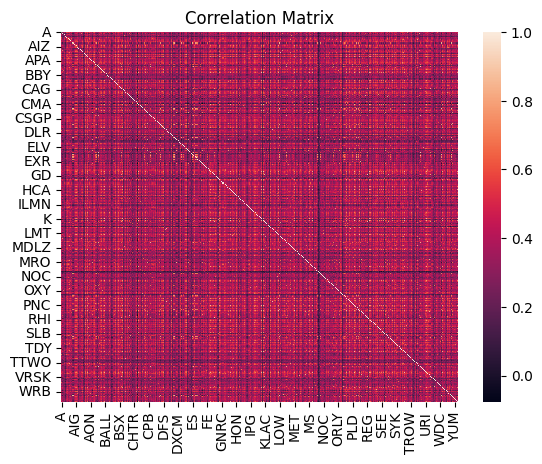

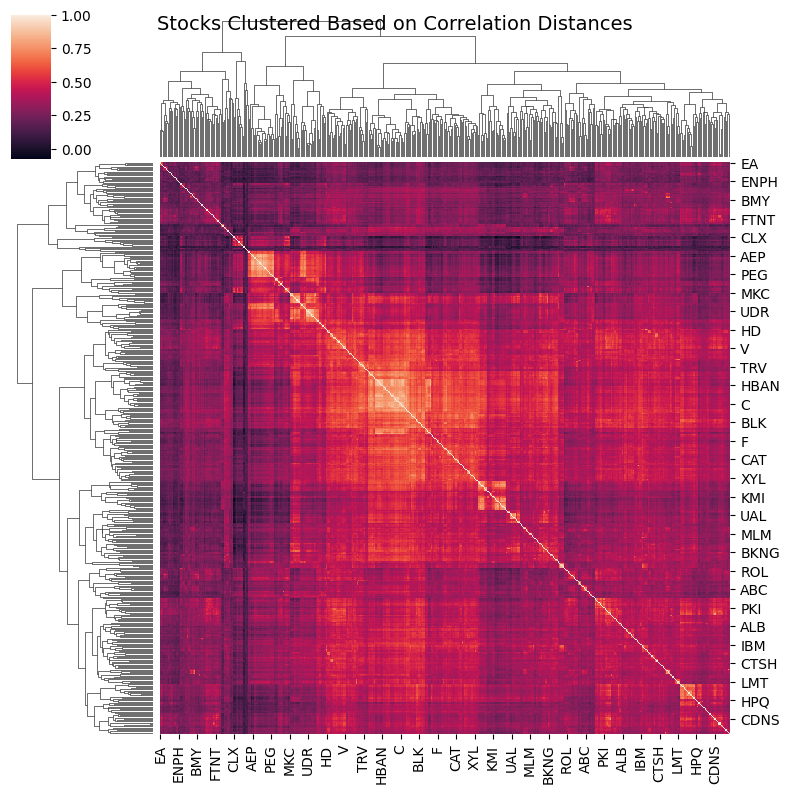

In [7]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr0)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr0, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

### 2. Denoise and Detone the Empirical correlation Matrix

Lets denoise the correlation matrix.

In [8]:
eVal0, eVec0, eVal1, eVec1, corr1, var0 = denoiseMatrix(corr0)

/Users/dario/Desktop/Projects/thesis/algorithm/thesis_venv/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 0.98, 'Stocks Clustered Based on Correlation Distances')

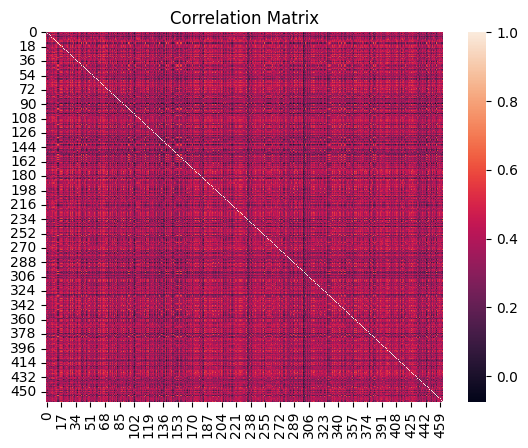

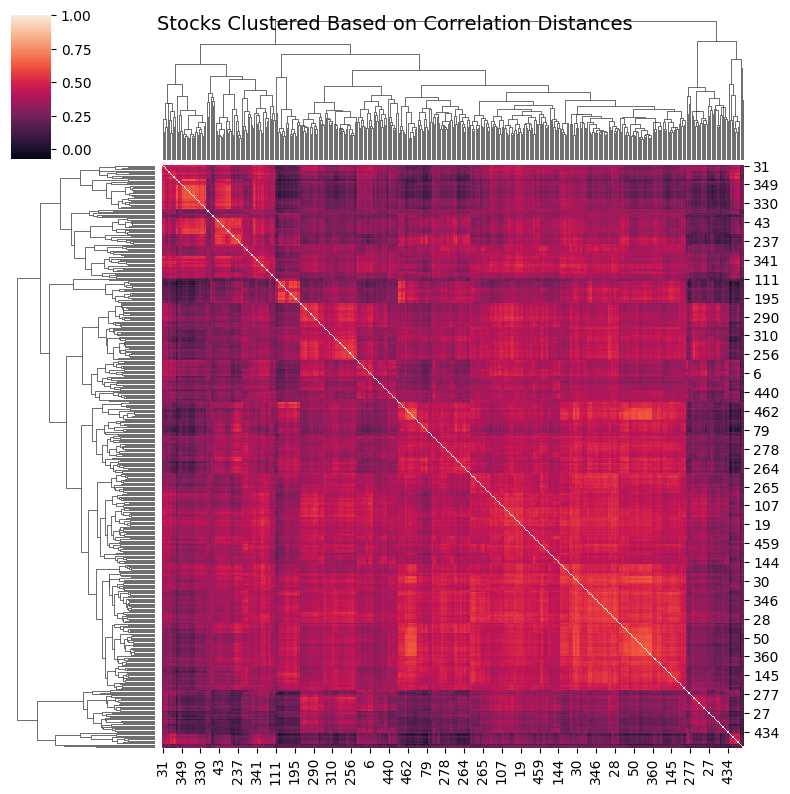

In [9]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr1)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr1, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

Next lets detone the correlation matrix.

In [10]:
corr2 = detoneMatrix(corr1, eVal1, eVec1)

Text(0.5, 0.98, 'Stocks Clustered Based on Correlation Distances')

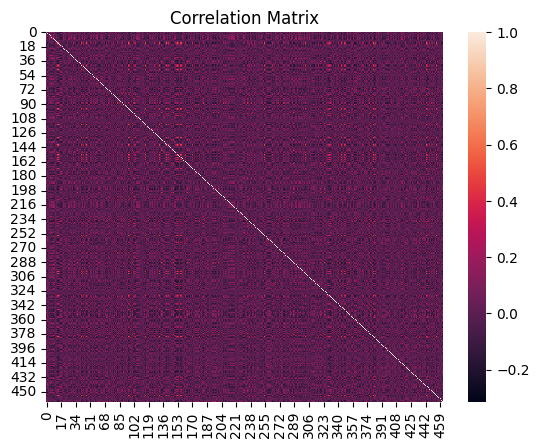

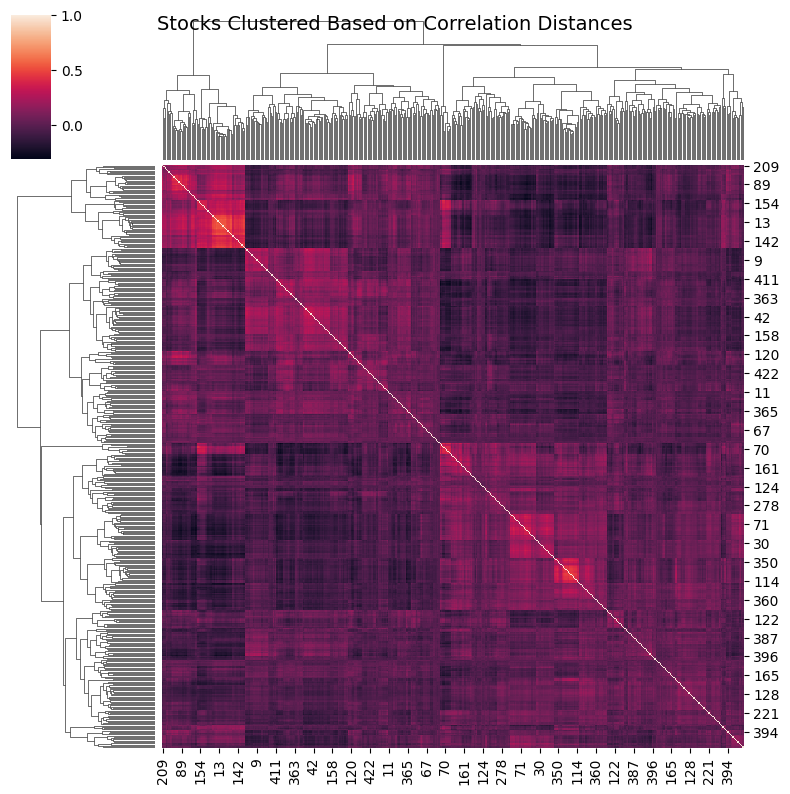

In [11]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr2)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr2, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

## 3. Distance Metrics

We will use the mikowski distance metric. Our denoised and detoned correlation matrix is transformed accordingly.

In [12]:
from sklearn.metrics import pairwise_distances

In [13]:
min_matrix = pd.DataFrame(pairwise_distances(corr2, metric = "minkowski"))

## 3. Portfolio Construction

#### 3.1 Clustering

##### 3.1.1 Finding the number of clusters

Our first method is the Elbow method

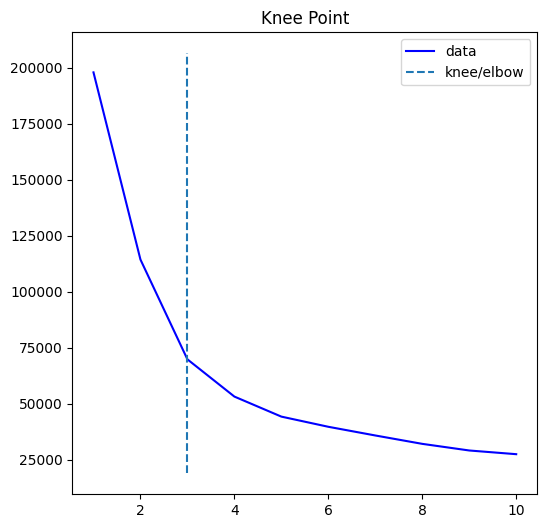

In [14]:
nr_clusters_sse = sse(min_matrix)

Now lets try the Silhouette method

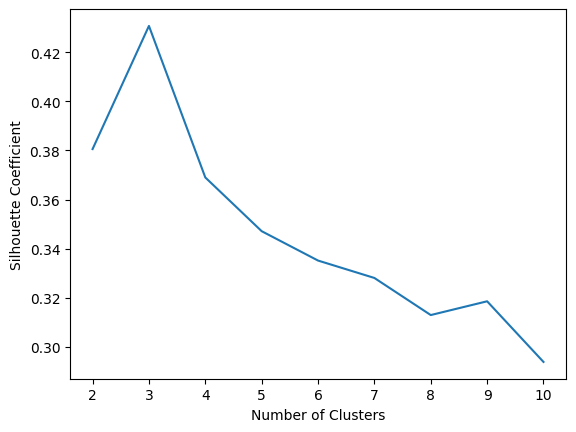

In [16]:
nr_clusters_sil = sil_score(min_matrix)

Our last method is the Davies-Boulding Score

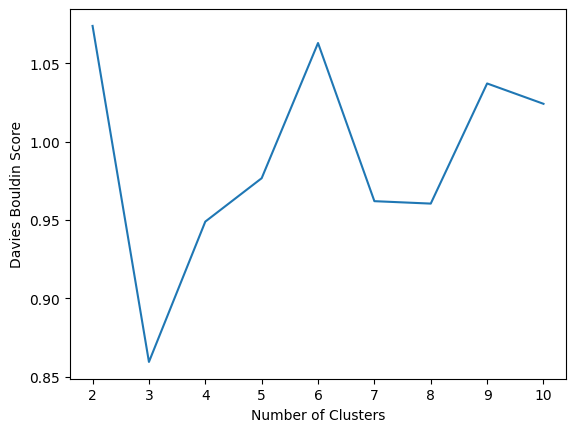

In [17]:
nr_clusters_db = db_score(min_matrix)

We will use the median number of clusters for for Kmeans.

##### 3.1.2 Running the clustering algorithm

In [18]:
def clusterKMeansBase(matrix, nrClusters=10, n_init=10):
    
    #find range of possible clusters with SSE, Silhouette, DBScore
    nr_clusters = np.array(nrClusters)
    clst = np.unique(nr_clusters)
    silh_coef_optimal = pd.Series(dtype='float64')

    for init in range(0, n_init):
    #The [outer] loop repeats the first loop multiple times, thereby obtaining different initializations. Ref: de Prado and Lewis (2018)
    #DETECTION OF FALSE INVESTMENT STRATEGIES USING UNSUPERVISED LEARNING METHODS
        for num_clusters in tqdm(clst):
            kmeans_ = KMeans(n_clusters=num_clusters, init = "random", n_init=10, max_iter=300)
            kmeans_ = kmeans_.fit(matrix)
            silh_coef = silhouette_samples(matrix, kmeans_.labels_)
            stat = (silh_coef.mean()/silh_coef.std(), silh_coef_optimal.mean()/silh_coef_optimal.std())

            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh_coef_optimal = silh_coef
                kmeans = kmeans_
                
    newIdx = np.argsort(kmeans.labels_)
    #print(kmeans.labels_)

    matrix1 = matrix.iloc[newIdx] #reorder rows
    matrix1 = matrix1.iloc[:, newIdx] #reorder columns

    clstrs = {i:matrix.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} #cluster members
    silh_coef_optimal = pd.Series(silh_coef_optimal, index= matrix.index)
    
    return matrix1, clstrs, silh_coef_optimal

In [20]:
matrix_min1, clusters, silcoefopt =  clusterKMeansBase(min_matrix, 3)

100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


#### 3.2 Portfolio allocation

In [86]:
def omega(returns, threshold):
    # Get excess return
    returns_exc = returns - threshold
    # Get sum of all values excess return above
    dfPositiveSum = sum(returns_exc[returns_exc > 0])
    # Get sum of all values excess return below
    dfNegativeSum = sum(returns_exc[returns_exc < 0])
    omega = dfPositiveSum/(-dfNegativeSum)
    return omega

In [85]:
np.array(df.iloc[:,3])-1

array([-0.99198044, -0.97632179, -1.00797178, ..., -1.03671867,
       -0.99764436, -1.01025497])

In [89]:
omega(df.iloc[:,3], 0.005)

0.5274885337492677

In [90]:
def optPortOmega(df, culsters, threshold, iterations = 25000):

    weights = np.array([])
    omega_score = float()
    dailyThreshold = (threshold + 1) ** np.sqrt(1/252) - 1

    print("Performing Monte-Carlo Simuluation to reach optimal weights.....\n")

    for i in tqdm(range(iterations)):

        #select random weights for portfolio holdings
        weights_ = np.array(np.random.random(len(df.columns)))
        #rebalance weights to sum to 1
        weights_ /= np.sum(weights_)

        #calculate returns
        returns = np.array(df.apply(lambda row: np.average(row, weights = weights_), axis=1))

        omega_score_ = omega(returns, dailyThreshold)

        if omega_score_ > omega_score:
            weights = weights_
            omega_score = omega_score_
        
    print("\n")
    print("Optimal weights were calculated sucessfully!")
    

    return weights, omega_score

In [91]:
optPortOmega(df, None, 0.5, iterations = 1000)

Performing Monte-Carlo Simuluation to reach optimal weights.....



 17%|█▋        | 169/1000 [01:00<04:57,  2.79it/s]


KeyboardInterrupt: 

## 4. Perfromance evaluation